# Import libraries

In [2]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

### Tensorflow dependencies ###
import tensorflow as tf

data_dir = '../../data/LungSegments'
img_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')

# Explore data

In [4]:
# Check number of masks and number of images
len_images = len(glob.glob(f'{img_dir}/*.png'))
len_masks = len(glob.glob(f'{mask_dir}/*.png'))

print(f'Number of images : {len_images}')
print(f'Number of masks : {len_masks}')

Number of images : 800
Number of masks : 704


### Pair the images with respective masks

In [5]:
# First, the mask naming convention is not consistent, rename them
for mask in glob.glob(f'{mask_dir}/*.png'):
    if(mask.endswith('_mask.png')):
        new_filename = mask.replace('_mask', '')
        os.rename(mask, new_filename)
        print(f'Renamed {mask} -> {new_filename}')

In [6]:
# Pair the images and the mask
counter = 0
image_files = []
mask_files = []

for mask in glob.glob(f'{mask_dir}/*.png'):
    filename = mask.split('/')[-1]
    
    respective_img = f'{img_dir}/{filename}'
    if(respective_img in glob.glob(f'{img_dir}/*.png')):
        mask_files.append(mask)
        image_files.append(respective_img)
        
print(f'Number of matching mask-image pairs : {len(mask_files)}')

Number of matching mask-image pairs : 704


### Construct a data pipeline

In [7]:
def map_fn(img, size=256):
    img = tf.image.resize(img, [size, size])
    img = tf.clip_by_value(img, 0, 255)
    img = img / 127.5 - 1.0
    
    return img

def parse_fn(img_file, mask_file):
    img = tf.io.read_file(img_file)
    img = tf.image.decode_png(img, 3)
    img = map_fn(img)
    
    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, 1)
    mask = tf.cast(mask, dtype=tf.float32)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0
    
    return img, mask

dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
dataset = dataset.map(parse_fn)
dataset = dataset.batch(16)
dataset = dataset.repeat(None).prefetch(1)

In [8]:
imgs, masks = next(iter(dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


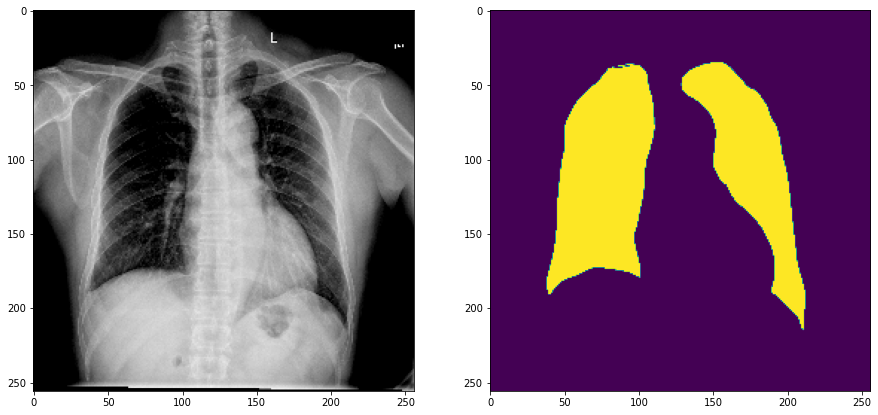

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax[0].imshow(imgs[0])
ax[1].imshow(masks[0])

plt.show()

# Test the dataloader

In [27]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from argparse import ArgumentParser

### Tensorflow dependencies ###
import tensorflow as tf

class DataLoader:
    def __init__(self, data_dir, batch_size, val_ratio):
        '''
            DataLoader constructor

            Arguments :
                data_dir : Data directory with images, masks sub directories
                batch_size : Number of instances per batch
                val_ration : Split ratio between test - overall dataset
        '''
        self.data_dir = data_dir 
        self.img_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')

        self.batch_size = batch_size
        self.val_ratio = val_ratio

        # Pair the images and the mask
        counter = 0
        self.image_files = []
        self.mask_files = []

        for mask in glob.glob(f'{self.mask_dir}/*.png'):
            filename = mask.split('/')[-1]
            
            respective_img = f'{self.img_dir}/{filename}'
            if(respective_img in glob.glob(f'{self.img_dir}/*.png')):
                self.mask_files.append(mask)
                self.image_files.append(respective_img)
                
        print(f'Number of matching mask-image pairs : {len(self.mask_files)}')

    @staticmethod
    def map_fn(img, size=256):
        img = tf.image.resize(img, [size, size])
        img = tf.clip_by_value(img, 0, 255)
        #img = img / 127.5 - 1.0
        
        mean = tf.math.reduce_mean(img)
        std = tf.math.reduce_std(img)
        img = (img - mean) / std

        return img

    @staticmethod
    def parse_fn(img_file, mask_file):
        img = tf.io.read_file(img_file)
        img = tf.image.decode_png(img, 3)
        img = DataLoader.map_fn(img)

        mask = tf.io.read_file(mask_file)
        mask = tf.image.decode_png(mask, 1)
        mask = tf.cast(mask, dtype=tf.float32)
        mask = tf.image.resize(mask, [256, 256])
        mask = mask / 255.0

        return img, mask

    def get_train_val_datasets(self):
        X_train, X_test, Y_train, Y_test = train_test_split(self.image_files, self.mask_files, test_size=self.val_ratio)
        self.train_steps = len(X_train) // self.batch_size + 1
        self.val_steps = len(X_test) // self.batch_size + 1

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_dataset = train_dataset.map(DataLoader.parse_fn)
        train_dataset = train_dataset.repeat()
        train_dataset = train_dataset.batch(self.batch_size)
        train_dataset = train_dataset.take(self.train_steps)

        val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
        val_dataset = val_dataset.map(DataLoader.parse_fn)
        val_dataset = val_dataset.repeat()
        val_dataset = val_dataset.batch(self.batch_size)
        val_dataset = val_dataset.take(self.val_steps)

        return train_dataset, val_dataset


In [28]:
loader = DataLoader('../../data/LungSegments', 16, 0.2)
train, val = loader.get_train_val_datasets()

Number of matching mask-image pairs : 704


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


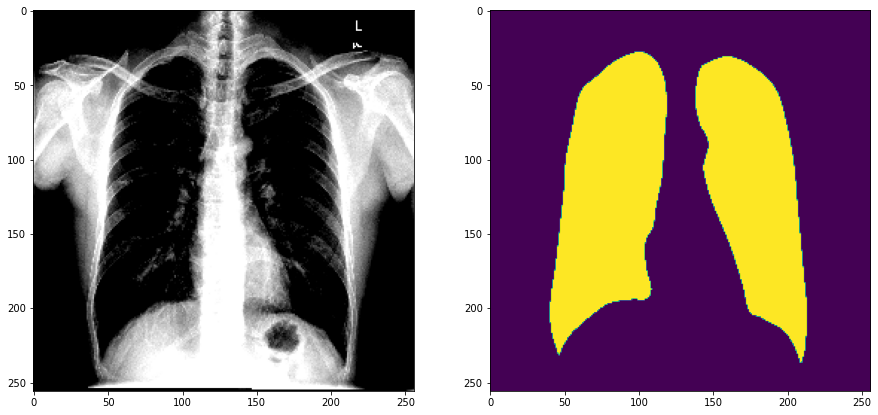

In [30]:
imgs, masks = next(iter(train))
imgs, masks = next(iter(train))

fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax[0].imshow(imgs[0])
ax[1].imshow(masks[0])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


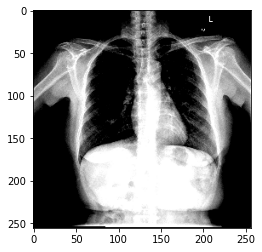

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


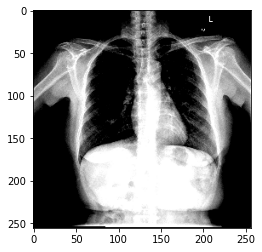

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


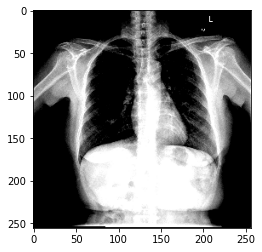

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


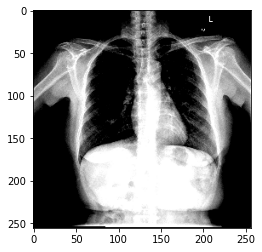

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


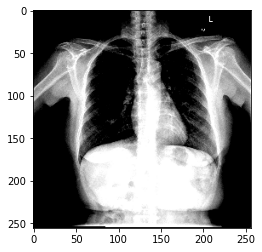

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


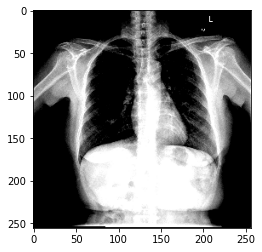

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

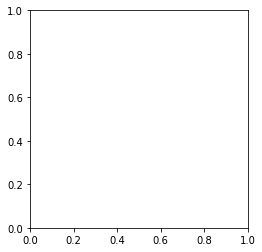

In [37]:
i = 0
for i in range(10):
    batch = next(iter(val))
    if(i == 10): break
    images, masks = batch
    plt.imshow(images[0])
    plt.show()